In [66]:
import pandas as pd
import numpy as np
from geopy.distance import geodesic 
import matplotlib.pyplot as plt
import math
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [67]:
data = pd.read_csv('data.csv')
data.sample(n=5)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
16070,3026059368,20140711T000000,814842.0,3,2.50,3190,6899,2.0,0,0,...,9,3190,0,2014,0,98034,47.7153,-122.221,3190,6899
3000,8732040090,20150506T000000,307450.0,4,2.75,2690,8874,1.0,0,0,...,8,1370,1320,1980,0,98023,47.3078,-122.383,1990,7875
18061,3574800090,20141202T000000,446950.0,5,2.50,2250,7945,1.0,0,0,...,7,1360,890,1977,0,98034,47.7316,-122.221,1820,7866
16116,8026200080,20140715T000000,372000.0,4,1.75,1890,10550,1.0,0,0,...,7,1010,880,1969,0,98056,47.5147,-122.193,1930,7291
18456,2372800100,20140925T000000,245000.0,3,1.50,1550,9126,1.0,0,0,...,7,1550,0,1957,0,98022,47.2012,-122.000,1450,9282


# Удалим столбцы, с которыми не планируем работать и обработаем некоторые выбросы

In [68]:
data = data.drop(['id','zipcode','lat','long', 'waterfront', 'grade', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15'], axis=1)

In [69]:
data.loc[data['yr_renovated'] == 0, ['yr_renovated']] = data['yr_built']
data['yr_built'] = data['date'].str[0:4].astype(int) - data['yr_built']
data['yr_renovated'] = data['date'].str[0:4].astype(int) - data['yr_renovated']
data = data.drop('date', axis=1)
data.sample(n=5)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,yr_built,yr_renovated
20946,280000.0,4,2.50,1934,5677,2.0,0,3,1,1
4290,192950.0,3,1.00,1170,3330,2.0,0,4,45,45
2275,610000.0,4,2.25,1660,7350,1.0,0,3,49,0
19533,450000.0,2,1.00,1180,10720,1.0,0,4,59,59
20803,536000.0,4,2.50,2520,4831,2.0,0,3,5,5


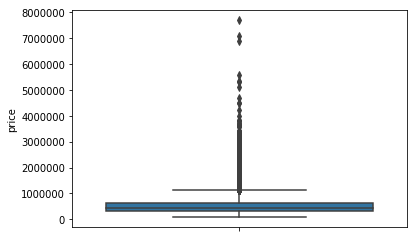

In [70]:
sns.boxplot(y='price', data=data)

In [71]:
data = data[data['price'] <= 1965000] #удалили очень дорогие дома
data = data[(data['bedrooms'] != 0) & (data['bathrooms'] != 0) & (data['bedrooms'] < 10)] #удалили дома без спален и ванных комнат, а еще странный дом с 33 спальнями

# Переведем все в метрическую систему

In [72]:
data.sample(n=5)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,yr_built,yr_renovated
8278,453000.0,3,1.75,1430,20193,1.0,0,3,59,59
2461,1700000.0,5,5.00,4930,14649,2.0,3,3,14,14
17675,325000.0,2,2.00,1040,5796,1.0,2,4,94,94
8696,225000.0,3,1.50,1240,5506,1.0,0,4,44,44
3269,805500.0,3,1.00,1440,10330,1.0,0,4,63,63


In [73]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21376 entries, 0 to 21612
Data columns (total 10 columns):
price           21376 non-null float64
bedrooms        21376 non-null int64
bathrooms       21376 non-null float64
sqft_living     21376 non-null int64
sqft_lot        21376 non-null int64
floors          21376 non-null float64
view            21376 non-null int64
condition       21376 non-null int64
yr_built        21376 non-null int64
yr_renovated    21376 non-null int64
dtypes: float64(3), int64(7)
memory usage: 1.8 MB


In [74]:
data['sqft_living'] = data['sqft_living'] / 0.093
data['sqft_lot'] = data['sqft_lot'] / 0.093
data['price'] = data['price'] * 72.64

In [75]:
data.sample(n=5)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,yr_built,yr_renovated
19101,41404800.0,4,2.50,36774.193548,1.241226e+06,2.0,0,3,25,25
178,19609168.0,3,1.50,20967.741935,8.129032e+04,1.0,2,4,39,39
17489,24690336.0,4,2.50,25161.290323,1.048172e+05,1.0,1,3,33,33
7321,25787200.0,3,1.75,25483.870968,1.048387e+05,1.0,0,4,35,35
21561,54480000.0,5,4.00,48387.096774,8.741935e+04,2.0,0,3,8,8


In [76]:
data.rename(columns={'sqft_living' : 'living_square', 'sqft_lot' : 'total_square'}, inplace=True)
data.sample(n=5)

,price,bedrooms,bathrooms,living_square,total_square,floors,view,condition,yr_built,yr_renovated
9648,26146768.0,3,2.50,23763.440860,67526.881720,2.0,0,3,11,11
9751,36320000.0,2,1.00,10860.215054,41774.193548,1.5,0,4,108,24
4532,30363520.0,4,3.00,25376.344086,67204.301075,1.0,2,3,54,54
13656,34830880.0,3,2.75,24731.182796,49860.215054,2.0,0,3,6,6
3076,81720000.0,5,3.25,33118.279570,144021.505376,1.0,2,4,47,47


In [77]:
data.to_csv('processed_data.csv', index=False)